In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

In [53]:
ALPHA=0.1
BETA=0.1
DELTA_MAX=0.02

In [54]:
import pandas as pd
import glob
import os

# Directory path
csv_dir = "/scratch/project/tcr_ml/gnn_release/icantcrscoring/model_2025_sc_curated/seekgene"

# Get all CSV files in the directory
csv_files = [
    f for f in glob.glob(os.path.join(csv_dir, "*.csv"))
    if os.path.basename(f) != "summary.csv"
]
# Load all CSV files into a list of DataFrames
dataframes = []
for file in csv_files:
    df = pd.read_csv(file)
    # Optional: add a column to track which file the data came from
    df['source_file'] = os.path.basename(file)
    dataframes.append(df)

# If you want to combine all DataFrames into one
combined_df = pd.concat(dataframes, ignore_index=True)

combined_df

,AA_seq,CloneFreq,prob,high,transformed_score,source_file
0,CASASDGAGDQPQHF,0.037352,0.920785,True,3.439338e-02,S2_merged.csv
1,CASSRAPASTEAFF,0.037352,0.423499,False,1.581865e-02,S2_merged.csv
2,CASSPGQGELFF,0.011348,0.256990,False,2.916200e-03,S2_merged.csv
3,CSARDRGGENTGELFF,0.008983,0.991506,True,8.907149e-03,S2_merged.csv
4,CSVPGTDYNEQFF,0.008983,0.004697,False,4.219959e-05,S2_merged.csv
...,...,...,...,...,...,...
5629,CSAPGTQIYEQYF,0.000386,0.251051,False,9.693102e-05,S3_merged.csv
5630,CASSLQVIGTDTQYF,0.000386,0.384414,False,1.484223e-04,S3_merged.csv
5631,CASSLTGLNTEAFF,0.000386,0.000260,False,1.004468e-07,S3_merged.csv
5632,CASSFQGTVYEQYF,0.000386,0.529522,False,2.044488e-04,S3_merged.csv


In [55]:
import numpy as np

# ----------------------------- Utilities -------------------------------- #

def _apply_open_interval(arr, open_interval: bool, eps: float):
    if not open_interval:
        return arr
    out = arr.copy()
    out[out <= 0.0] = eps
    out[out >= 1.0] = 1.0 - eps
    return out

def _plotting_position(ranks, m, method: str):
    if method == "weibull":
        return ranks / (m + 1.0)
    if method == "hazen":
        return (ranks - 0.5) / m
    if method == "blom":
        return (ranks - 0.375) / (m + 0.25)
    if method == "bernard":
        return (ranks - 3.0/8.0) / (m + 0.25)
    if method == "rank":
        return np.full(m, 0.5) if m == 1 else (ranks - 1.0) / (m - 1.0)
    raise ValueError(f"Unknown method '{method}'")

def _midranks_for_ties(sorted_vals_len: int, diffs: np.ndarray):
    # diffs is np.diff of sorted values
    # build tie groups, assign midranks in 1..m
    m = sorted_vals_len
    if m == 0:
        return np.empty(0, dtype=float)
    boundaries = np.flatnonzero(diffs != 0.0)
    starts = np.r_[0, boundaries + 1]
    stops = np.r_[boundaries, m - 1]
    ranks = np.empty(m, dtype=float)
    for s, e in zip(starts, stops):
        mid = (s + e) / 2.0
        ranks[s:e+1] = mid + 1.0
    return ranks

# ----------------------------- Main API ---------------------------------- #

def fraction_to_percentile(
    x,
    weights=None,
    method="hazen",          # "weibull", "hazen", "blom", "bernard", "rank"
    open_interval=False,     # map [0,1] to (eps,1-eps) if True
    eps=1e-9,
    nan_policy="omit"        # "omit", "propagate", "raise"
):
    """
    Percentile transform via ECDF with optional weights and plotting positions.

    Unweighted case uses chosen plotting position with midranks for ties.
    Weighted case uses midpoint-of-jump ECDF which is method-free.

    Returns array of percentiles aligned with x.
    """
    x = np.asarray(x, dtype=float)
    n = x.size
    if n == 0:
        return x

    # NaN handling
    has_nan = np.isnan(x).any()
    if has_nan:
        if nan_policy == "raise":
            raise ValueError("NaNs present with nan_policy='raise'.")
        if nan_policy == "propagate":
            return np.full_like(x, np.nan, dtype=float)

    # Weights
    if weights is None:
        w = np.ones_like(x, dtype=float)
    else:
        w = np.asarray(weights, dtype=float)
        if w.shape != x.shape:
            raise ValueError("weights must have same shape as x")
        if np.any(w < 0):
            raise ValueError("weights must be nonnegative")

    # Filter valid
    valid = ~np.isnan(x)
    xv = x[valid]
    wv = w[valid]
    m = xv.size

    out = np.full_like(x, np.nan, dtype=float)
    if m == 0:
        return out
    if m == 1:
        out[valid] = 0.5
        return _apply_open_interval(out, open_interval, eps)

    # Sort by value
    order = np.argsort(xv, kind="mergesort")
    xv_sorted = xv[order]
    wv_sorted = wv[order]

    # Unweighted branch if all weights are 1
    if weights is None or np.allclose(wv_sorted, 1.0):
        diffs = np.diff(xv_sorted)
        ranks = _midranks_for_ties(len(xv_sorted), diffs)
        p_sorted = _plotting_position(ranks, m, method)
    else:
        # Weighted midpoint-of-jump ECDF at unique values
        uniq_vals, idx_start, counts = np.unique(
            xv_sorted, return_index=True, return_counts=True
        )
        group_weights = np.add.reduceat(wv_sorted, idx_start)
        cw = np.cumsum(group_weights)
        total = cw[-1]
        cw_prev = cw - group_weights
        p_group = (cw_prev + 0.5 * group_weights) / total
        p_sorted = np.repeat(p_group, counts)

    # Unsort back to valid positions
    inv = np.empty(m, dtype=int)
    inv[order] = np.arange(m)
    out[valid] = p_sorted[inv]
    return _apply_open_interval(out, open_interval, eps)

def combined_score_sample_capped(
    P,
    F_raw,
    t_P=0.5,
    t_R=0.5,
    alpha=0.6,
    beta=0.9,
    delta_max=0.25,
    floor=0.01,
    ceil=0.99,
):
    """
    Threshold-based score adjustment with cap and final clipping.
    Returns (S, R) where R is percentile of F_raw from fraction_to_percentile.
    """
    P = np.clip(np.asarray(P, dtype=float), 0.0, 1.0)
    R = fraction_to_percentile(F_raw)

    mask_high = (P > t_P) & (R > t_R)
    mask_low = (P < t_P) & (R < t_R)

    # Amounts only where relevant
    A_high = np.where(mask_high, np.minimum(P, R), 0.0)
    A_low = np.where(mask_low, np.minimum(1.0 - P, 1.0 - R), 0.0)

    delta = alpha * A_high - beta * A_low
    delta = np.clip(delta, -delta_max, delta_max)

    S = np.clip(P + delta, floor, ceil)
    return S, R


In [56]:
def sample_skewness(x):
    """
    Compute the Fisher-Pearson sample skewness of a 1D array or list of numbers.

    Skewness measures the asymmetry of a distribution:
        - Positive skew → tail on the right (larger values)
        - Negative skew → tail on the left (smaller values)
        - Zero skew → symmetric distribution

    The Fisher-Pearson definition is used here:
        skewness = (1/n) * Σ((x_i - μ)^3) / σ^3
    where μ is the mean and σ is the standard deviation of the sample.

    Parameters
    ----------
    x : array-like
        Input data (list, array, or Series). Will be converted to a NumPy array of floats.

    Returns
    -------
    float
        The skewness value. Returns 0.0 if the sample has fewer than 3 elements or zero variance.

    Notes
    -----
    - This implementation uses the population standard deviation (ddof=0) for consistency with
      transformations that map skew to score adjustments.
    - For small samples (n < 3), skewness is not defined, so it returns 0.
    - Zero variance arrays also return 0 to avoid division by zero.

    Examples
    --------
    >>> sample_skewness([1, 2, 3, 4, 5])
    0.0
    >>> sample_skewness([1, 2, 3, 4, 10])
    1.174
    >>> sample_skewness([10, 8, 6, 4, 2])
    -0.0
    """
    import numpy as np

    # Convert input to a NumPy array of floats
    x = np.asarray(x, dtype=float)

    # Number of elements
    n = x.size
    if n < 3:
        # Skewness undefined for fewer than 3 points
        return 0.0

    # Compute mean
    mu = x.mean()

    # Compute population standard deviation (ddof=0)
    s = x.std(ddof=0)
    if s == 0:
        # Avoid division by zero for constant arrays
        return 0.0

    # Compute third central moment
    m3 = np.mean((x - mu) ** 3)

    # Return skewness = m3 / std^3
    return m3 / (s**3)


def combined_score_distribution_aware_simple(
    P,
    scale_strength=0.6,
    skew_strength=0.5,
    clip_strength=0.2,
    skew_power=0.5,
    floor=0.0,
    ceil=1.0,
    option=1,
):
    """
    Apply a simple global skew-based adjustment to a score vector.

    This function shifts all values in P depending on the skew of the distribution:
    - Right-skewed → scores pushed downward
    - Left-skewed  → scores pushed upward

    Parameters
    ----------
    P : array-like
        Original scores (values between 0 and 1). Will be clipped to [0,1].
    scale_strength : float, default=0.6
        Maximum magnitude of shift for option 2 (power-law). Ignored in option 1.
    skew_strength : float, default=0.5
        Multiplier for skew in option 1 (tanh). Ignored in option 2.
    clip_strength : float, default=0.2
        Maximum absolute adjustment in option 1 (tanh). Ignored in option 2.
    skew_power : float, default=0.5
        Power exponent used in option 2 to nonlinearly scale skew magnitude. Ignored in option 1.
    floor : float, default=0.0
        Minimum allowed value after adjustment.
    ceil : float, default=1.0
        Maximum allowed value after adjustment.
    option : int, default=1
        Choice of adjustment method:
        - 1 : Conservative adjustment using hyperbolic tangent (tanh).
              Caps adjustment to [-clip_strength, +clip_strength].
              Small skew → small adjustment; large skew → saturates.
        - 2 : Aggressive, power-law scaling of skew magnitude.
              Adjustment = -sign(skew) * (abs(skew) ** skew_power) * scale_strength.
              Preserves skew direction and magnitude; allows stronger effect.

    Returns
    -------
    P_adj : array-like
        Adjusted scores, clipped to [floor, ceil].
    info : dict
        Dictionary containing:
        - "skew": computed skew of input P
        - "adjustment": the global shift applied to all values

    Notes
    -----
    - Option 1 is safer and more conservative, suitable for small shifts.
    - Option 2 respects the skew magnitude more and can produce more noticeable mean shifts,
      potentially pushing some values to the floor or ceil.
    """

    import numpy as np
    from scipy.stats import skew

    P = np.clip(P, 0.0, 1.0)
    s = skew(P)

    # Compute adjustment direction and magnitude
    if option == 1:
        adj = -np.tanh(s * skew_strength) * clip_strength
    elif option == 2:
        adj = -np.sign(s) * (abs(s) ** skew_power) * scale_strength
    # adj = -np.sign(s) * scale_strength  # ignore small s

    # Apply global shift
    P_adj = np.clip(P + adj, floor, ceil)

    return P_adj  # , {"skew": s, "adjustment": adj}

In [57]:
import numpy as np

# # Apply the function to the DataFrame
# S, R = combined_score_sample_capped(
#     P=combined_df["prob"].values,
#     F_raw=combined_df["CloneFreq"].values,
#     t_P=0.5,
#     t_R=0.5,
#     alpha=ALPHA,
#     beta=BETA,
#     delta_max=DELTA_MAX,
#     floor=0.01,
#     ceil=0.99,
# )
S = combined_score_distribution_aware_simple(
    P=combined_df["prob"].values)
# Add results back to the DataFrame
combined_df["score_adj"] = S
# combined_df["CloneFreq_percentile"] = R


In [58]:
combined_df

,AA_seq,CloneFreq,prob,high,transformed_score,source_file,score_adj
0,CASASDGAGDQPQHF,0.037352,0.920785,True,3.439338e-02,S2_merged.csv,0.919869
1,CASSRAPASTEAFF,0.037352,0.423499,False,1.581865e-02,S2_merged.csv,0.422583
2,CASSPGQGELFF,0.011348,0.256990,False,2.916200e-03,S2_merged.csv,0.256074
3,CSARDRGGENTGELFF,0.008983,0.991506,True,8.907149e-03,S2_merged.csv,0.990590
4,CSVPGTDYNEQFF,0.008983,0.004697,False,4.219959e-05,S2_merged.csv,0.003782
...,...,...,...,...,...,...,...
5629,CSAPGTQIYEQYF,0.000386,0.251051,False,9.693102e-05,S3_merged.csv,0.250135
5630,CASSLQVIGTDTQYF,0.000386,0.384414,False,1.484223e-04,S3_merged.csv,0.383498
5631,CASSLTGLNTEAFF,0.000386,0.000260,False,1.004468e-07,S3_merged.csv,0.000000
5632,CASSFQGTVYEQYF,0.000386,0.529522,False,2.044488e-04,S3_merged.csv,0.528606


In [59]:
import numpy as np
import pandas as pd


def summarize_probs(x, temperature=1.5):
    """Return all summary metrics for an array of probabilities, including softmax pooling."""
    x = np.clip(np.asarray(x, dtype=float), 1e-9, 1 - 1e-9)
    logits = np.log(x / (1 - x))
    
    # Softmax pooling: smooth max of logits
    # smaller temperature -> more weight to high logits
    logsumexp = np.log(np.mean(np.exp(logits / temperature)))
    softmax_pool = 1 / (1 + np.exp(-logsumexp))
    
    return pd.Series({
        "arithmetic_mean": np.mean(x),
        "median": np.median(x),
        "geometric_mean": np.exp(np.mean(np.log(x))),
        "inv_logit_mean": 1 / (1 + np.exp(-np.mean(logits))),
        "softmax_pool": softmax_pool,
        "mean_logit": np.mean(logits)
    })


# group by source_file and apply the summary function
summary_by_source = combined_df.groupby("source_file")["score_adj"].apply(summarize_probs)
# summarize for score_adj
summary_by_source = combined_df.groupby("source_file")["score_adj"].apply(summarize_probs).reset_index()

# compute arithmetic mean of untransformed 'prob'
old_means = (
    combined_df.groupby("source_file")["prob"]
    .mean()
    .rename("score_adj")  # same column name for consistency
    .reset_index()
)
old_means["level_1"] = "old_arithmetic_mean"

# append as new rows
summary_by_source = pd.concat([summary_by_source, old_means], ignore_index=True)

# optional: reorder columns
summary_by_source = summary_by_source[["source_file", "level_1", "score_adj"]]

# if you want it as a clean dataframe instead of hierarchical columns
summary_by_source = summary_by_source.reset_index()

print(summary_by_source)


    index    source_file              level_1  score_adj
0       0  S1_merged.csv      arithmetic_mean   0.516869
1       1  S1_merged.csv               median   0.513149
2       2  S1_merged.csv       geometric_mean   0.179684
3       3  S1_merged.csv       inv_logit_mean   0.533937
4       4  S1_merged.csv         softmax_pool   0.934555
5       5  S1_merged.csv           mean_logit   0.135956
6       6  S2_merged.csv      arithmetic_mean   0.501013
7       7  S2_merged.csv               median   0.477566
8       8  S2_merged.csv       geometric_mean   0.169149
9       9  S2_merged.csv       inv_logit_mean   0.497321
10     10  S2_merged.csv         softmax_pool   0.929557
11     11  S2_merged.csv           mean_logit  -0.010718
12     12  S3_merged.csv      arithmetic_mean   0.501056
13     13  S3_merged.csv               median   0.473230
14     14  S3_merged.csv       geometric_mean   0.157609
15     15  S3_merged.csv       inv_logit_mean   0.479789
16     16  S3_merged.csv       

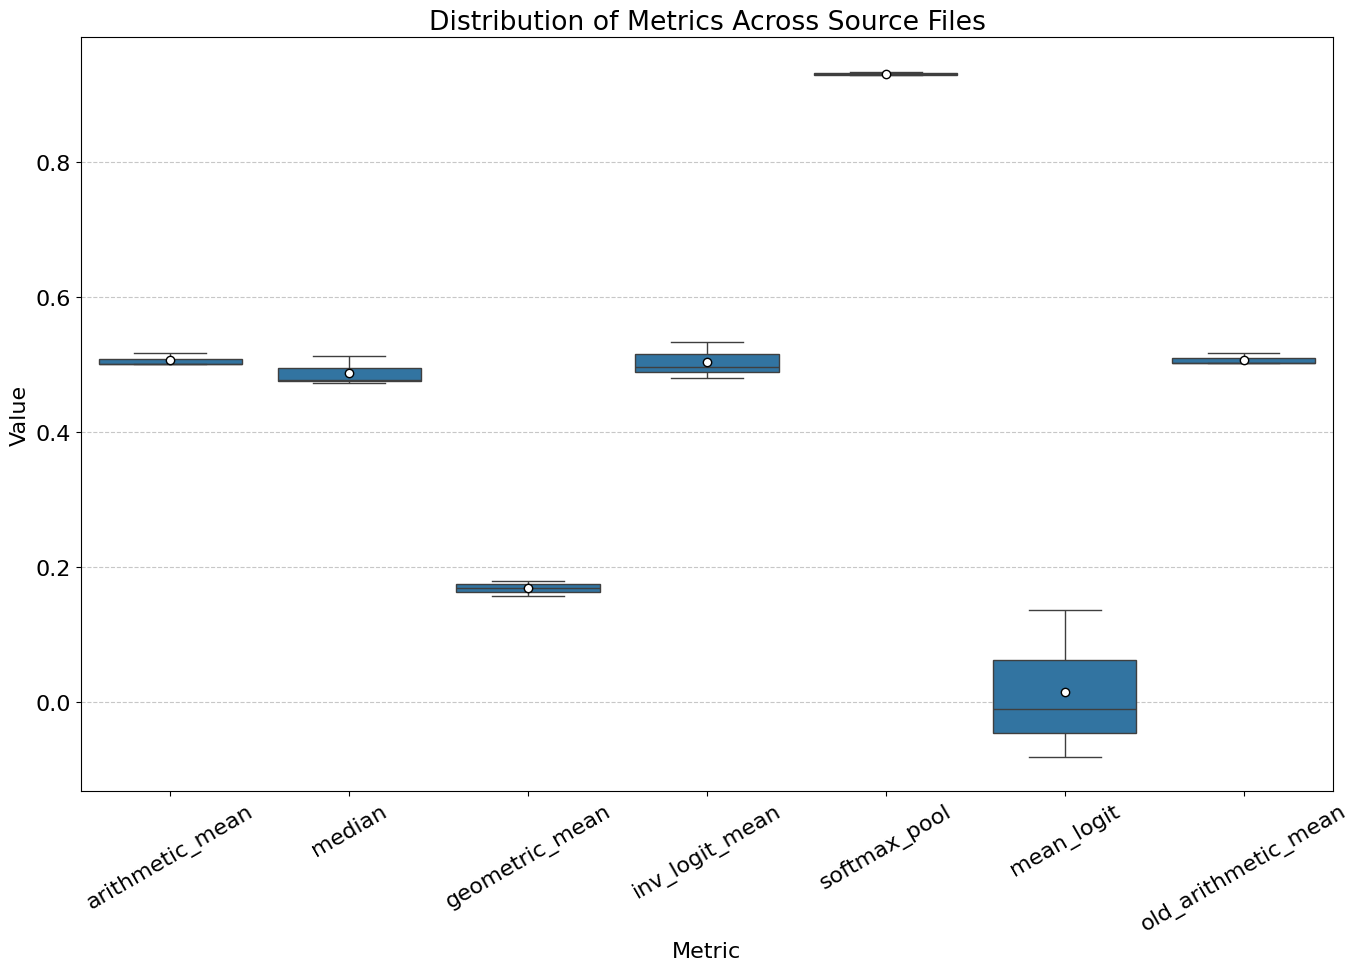

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure your DataFrame is named correctly, e.g.:
df_summary = summary_by_source  # or whatever variable you used

plt.figure(figsize=(14, 10))
sns.boxplot(data=df_summary, x="level_1", y="score_adj", showmeans=True,
            meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"})

plt.title("Distribution of Metrics Across Source Files")
plt.xlabel("Metric")
plt.ylabel("Value")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [61]:
# Directory path
csv_dir = "/scratch/project/tcr_ml/gnn_release/icantcrscoring/model_2025_sc_curated/PICA"

# Get all CSV files in the directory
csv_files = [
    f for f in glob.glob(os.path.join(csv_dir, "*.csv"))
    if os.path.basename(f) != "summary.csv"
]
# Load all CSV files into a list of DataFrames
dataframes = []
for file in csv_files:
    df = pd.read_csv(file)
    # Optional: add a column to track which file the data came from
    df['source_file'] = os.path.basename(file)
    dataframes.append(df)

# If you want to combine all DataFrames into one
combined_control_df = pd.concat(dataframes, ignore_index=True)

combined_control_df

,AA_seq,CloneFreq,prob,high,transformed_score,source_file
0,CASTPGDEQYF,0.003607,0.575344,False,0.002075,20240918_WGS_20240924_sc_PICA0008-PICA0032_Poo...
1,CASSLGSGQYF,0.001945,0.588268,False,0.001144,20240918_WGS_20240924_sc_PICA0008-PICA0032_Poo...
2,CASSLGSGQYF,0.001945,0.588268,False,0.001144,20240918_WGS_20240924_sc_PICA0008-PICA0032_Poo...
3,CASSLGSGQYF,0.001945,0.588268,False,0.001144,20240918_WGS_20240924_sc_PICA0008-PICA0032_Poo...
4,CASSLGSGQYF,0.001945,0.588268,False,0.001144,20240918_WGS_20240924_sc_PICA0008-PICA0032_Poo...
...,...,...,...,...,...,...
149200,CATSDSTRGDSYNEQFF,0.000038,0.144616,False,0.000005,20241106_WGS_20241106_sc_PICA0033-PICA0069_Poo...
149201,CSAGGDRSNQPQHF,0.000038,0.086664,False,0.000003,20241106_WGS_20241106_sc_PICA0033-PICA0069_Poo...
149202,CSAREPGSSPLHF,0.000038,0.909164,True,0.000035,20241106_WGS_20241106_sc_PICA0033-PICA0069_Poo...
149203,CAISETSEVGYEQYF,0.000038,0.329552,False,0.000013,20241106_WGS_20241106_sc_PICA0033-PICA0069_Poo...


In [62]:
import numpy as np

# # Apply the function to the DataFrame
# S, R = combined_score_sample_capped(
#     P=combined_control_df["prob"].values,
#     F_raw=combined_control_df["CloneFreq"].values,
#     t_P=0.5,
#     t_R=0.5,
#     alpha=ALPHA,
#     beta=BETA,
#     delta_max=DELTA_MAX,
#     floor=0.01,
#     ceil=0.99,
# )

S = combined_score_distribution_aware_simple(
    P=combined_control_df["prob"].values)
# Add results back to the DataFrame
combined_control_df["score_adj"] = S

# Add results back to the DataFrame
combined_control_df["score_adj"] = S
# combined_control_df["CloneFreq_percentile"] = R
combined_control_df

,AA_seq,CloneFreq,prob,high,transformed_score,source_file,score_adj
0,CASTPGDEQYF,0.003607,0.575344,False,0.002075,20240918_WGS_20240924_sc_PICA0008-PICA0032_Poo...,0.559463
1,CASSLGSGQYF,0.001945,0.588268,False,0.001144,20240918_WGS_20240924_sc_PICA0008-PICA0032_Poo...,0.572387
2,CASSLGSGQYF,0.001945,0.588268,False,0.001144,20240918_WGS_20240924_sc_PICA0008-PICA0032_Poo...,0.572387
3,CASSLGSGQYF,0.001945,0.588268,False,0.001144,20240918_WGS_20240924_sc_PICA0008-PICA0032_Poo...,0.572387
4,CASSLGSGQYF,0.001945,0.588268,False,0.001144,20240918_WGS_20240924_sc_PICA0008-PICA0032_Poo...,0.572387
...,...,...,...,...,...,...,...
149200,CATSDSTRGDSYNEQFF,0.000038,0.144616,False,0.000005,20241106_WGS_20241106_sc_PICA0033-PICA0069_Poo...,0.128735
149201,CSAGGDRSNQPQHF,0.000038,0.086664,False,0.000003,20241106_WGS_20241106_sc_PICA0033-PICA0069_Poo...,0.070783
149202,CSAREPGSSPLHF,0.000038,0.909164,True,0.000035,20241106_WGS_20241106_sc_PICA0033-PICA0069_Poo...,0.893283
149203,CAISETSEVGYEQYF,0.000038,0.329552,False,0.000013,20241106_WGS_20241106_sc_PICA0033-PICA0069_Poo...,0.313671


In [63]:
import numpy as np
import pandas as pd


# summarize for score_adj
summary_by_source = combined_control_df.groupby("source_file")["score_adj"].apply(summarize_probs).reset_index()

# compute arithmetic mean of untransformed 'prob'
old_means = (
    combined_control_df.groupby("source_file")["prob"]
    .mean()
    .rename("score_adj")  # same column name for consistency
    .reset_index()
)
old_means["level_1"] = "old_arithmetic_mean"

# append as new rows
summary_by_source = pd.concat([summary_by_source, old_means], ignore_index=True)

# optional: reorder columns
summary_by_source = summary_by_source[["source_file", "level_1", "score_adj"]]

summary_by_source


,source_file,level_1,score_adj
0,20240530_WGS_20240530_sc_PICA0001-PICA0007_PMI...,arithmetic_mean,0.447933
1,20240530_WGS_20240530_sc_PICA0001-PICA0007_PMI...,median,0.384824
2,20240530_WGS_20240530_sc_PICA0001-PICA0007_PMI...,geometric_mean,0.029739
3,20240530_WGS_20240530_sc_PICA0001-PICA0007_PMI...,inv_logit_mean,0.085120
4,20240530_WGS_20240530_sc_PICA0001-PICA0007_PMI...,softmax_pool,0.740951
...,...,...,...
163,20250114_WGS_20241218_sc_PICA0071-PICA0097_Poo...,old_arithmetic_mean,0.459785
164,20250114_WGS_20241218_sc_PICA0071-PICA0097_Poo...,old_arithmetic_mean,0.469870
165,20250114_WGS_20241218_sc_PICA0071-PICA0097_Poo...,old_arithmetic_mean,0.462667
166,20250114_WGS_20241218_sc_PICA0071-PICA0097_Poo...,old_arithmetic_mean,0.467074


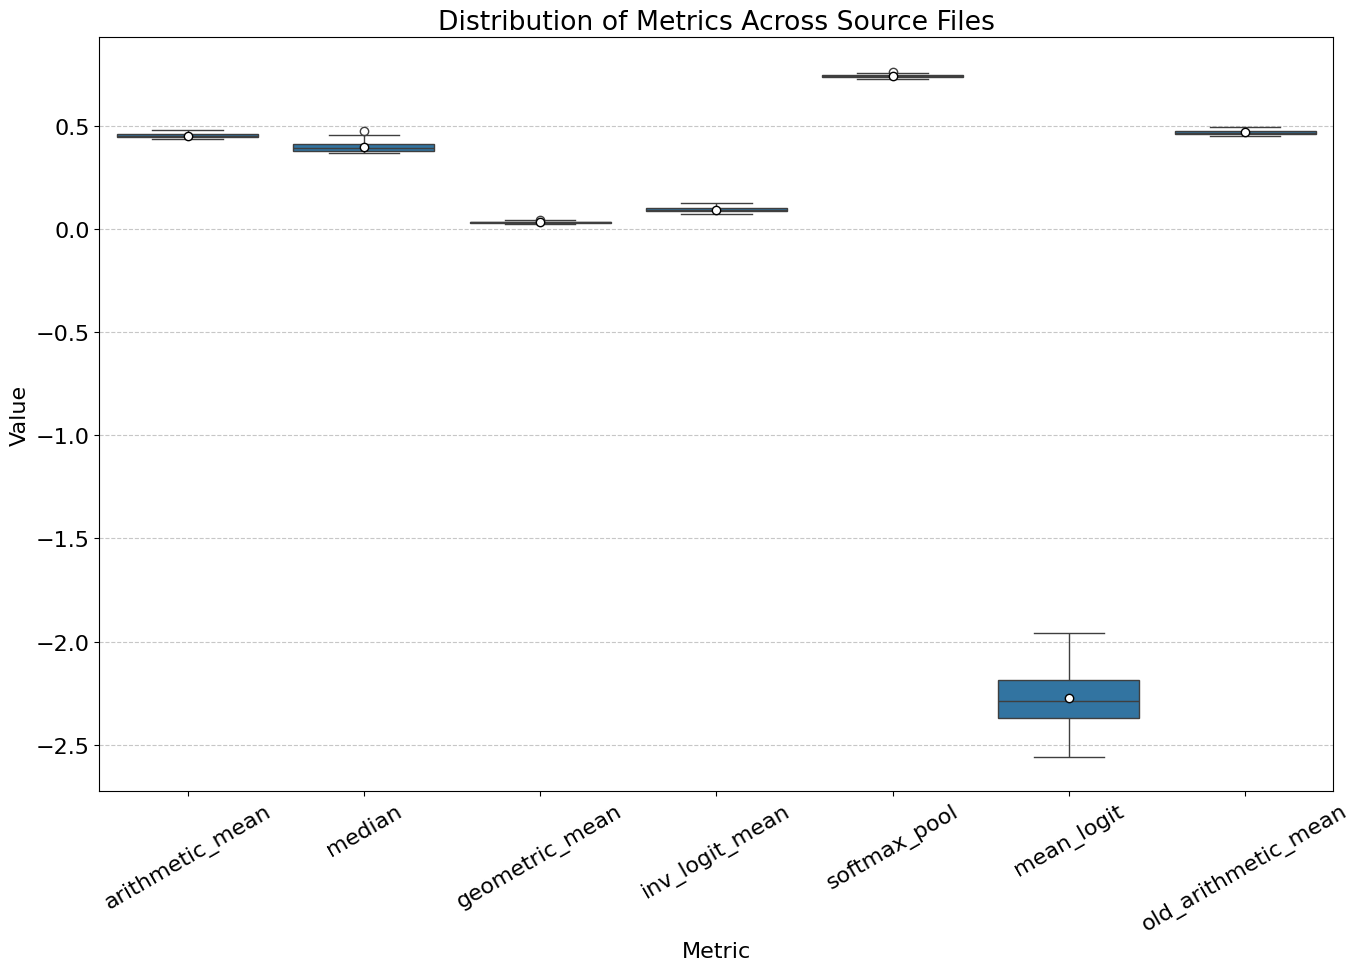

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure your DataFrame is named correctly, e.g.:
df_summary_control = summary_by_source  # or whatever variable you used

plt.figure(figsize=(14, 10))
sns.boxplot(data=df_summary_control, x="level_1", y="score_adj", showmeans=True,
            meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"})

plt.title("Distribution of Metrics Across Source Files")
plt.xlabel("Metric")
plt.ylabel("Value")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


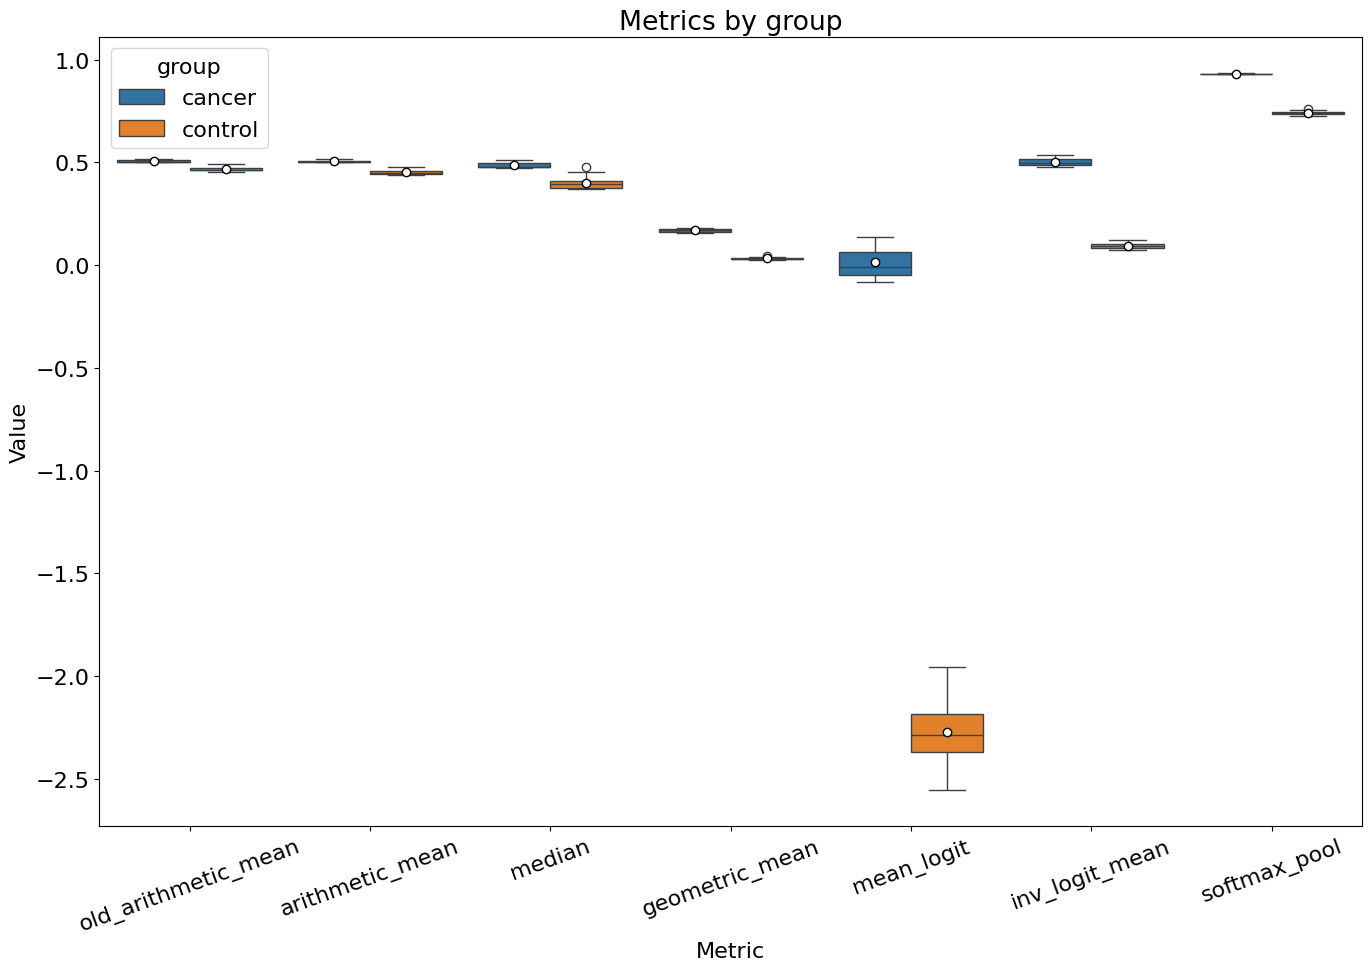

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Tag and combine
dfc = df_summary.copy()
dfc["group"] = "cancer"
dfk = df_summary_control.copy()
dfk["group"] = "control"
df_long = pd.concat([dfc, dfk], ignore_index=True)

# Pick metric order if you want consistent x positions
metrics = ["old_arithmetic_mean","arithmetic_mean", "median", "geometric_mean", "mean_logit", "inv_logit_mean","softmax_pool"]
metrics = [m for m in metrics if m in df_long["level_1"].unique()]

plt.figure(figsize=(14, 10))
sns.boxplot(
    data=df_long,
    x="level_1",
    y="score_adj",
    hue="group",
    order=metrics,
    showmeans=True,
    meanprops={"marker":"o","markerfacecolor":"white","markeredgecolor":"black"}
)
plt.title("Metrics by group")
plt.xlabel("Metric")
plt.ylabel("Value")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


/scratch/temp/17728189/ipykernel_652457/3826073489.py:35: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr, fpr)


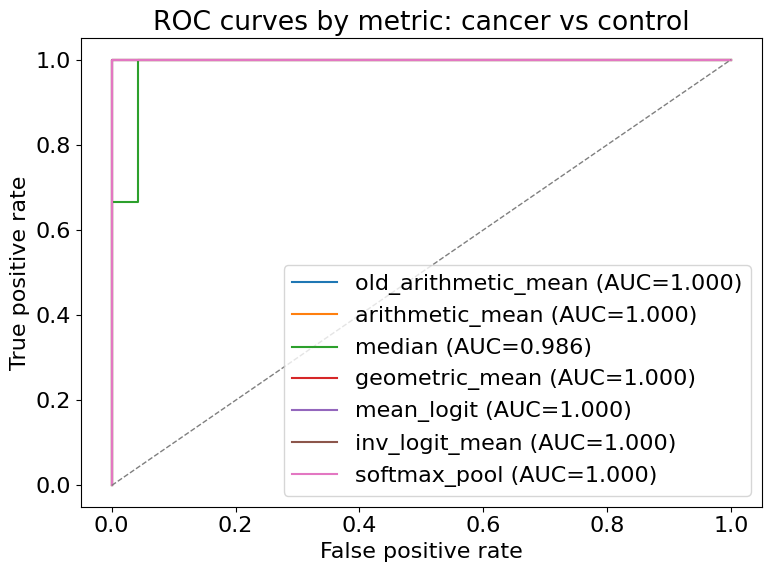

             metric      auc
old_arithmetic_mean 1.000000
    arithmetic_mean 1.000000
     geometric_mean 1.000000
     inv_logit_mean 1.000000
         mean_logit 1.000000
       softmax_pool 1.000000
             median 0.986111


In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Expecting:
# df_summary, df_summary_control with columns: ["source_file", "level_1", "score_adj"]

def roc_curve_manual(y_true: np.ndarray, y_score: np.ndarray):
    y_true = y_true.astype(int)
    order = np.argsort(-y_score)              # sort by score desc
    y_true_sorted = y_true[order]
    y_score_sorted = y_score[order]

    P = y_true_sorted.sum()
    N = len(y_true_sorted) - P
    if P == 0 or N == 0:
        # cannot compute ROC if only one class present
        return np.array([0.0, 1.0]), np.array([0.0, 1.0]), np.nan

    tps = np.cumsum(y_true_sorted)
    fps = np.cumsum(1 - y_true_sorted)

    # take points only where score changes, plus last point
    diffs = np.diff(y_score_sorted)
    idx = np.where(diffs != 0)[0]
    idx = np.r_[idx, len(y_true_sorted) - 1]

    tpr = tps[idx] / P
    fpr = fps[idx] / N

    # add origin
    tpr = np.r_[0.0, tpr]
    fpr = np.r_[0.0, fpr]

    auc = np.trapz(tpr, fpr)
    return fpr, tpr, auc

# Tag group and combine
dfc = df_summary.copy();            dfc["group"] = "cancer"
dfk = df_summary_control.copy();    dfk["group"] = "control"
df_long = pd.concat([dfc, dfk], ignore_index=True)

# Coerce numeric
df_long["score_adj"] = pd.to_numeric(df_long["score_adj"], errors="coerce")

# Which metrics to compare
metrics = ["old_arithmetic_mean","arithmetic_mean", "median", "geometric_mean", "mean_logit", "inv_logit_mean","softmax_pool"]
metrics = [m for m in metrics if m in df_long["level_1"].unique()]

# Plot ROC curves
plt.figure(figsize=(8, 6))
auc_rows = []

for m in metrics:
    sub = df_long[df_long["level_1"] == m].dropna(subset=["score_adj", "group"])
    if sub.empty:
        continue
    y_true = (sub["group"].values == "cancer").astype(int)
    y_score = sub["score_adj"].values.astype(float)

    fpr, tpr, auc = roc_curve_manual(y_true, y_score)
    auc_rows.append({"metric": m, "auc": auc})

    plt.plot(fpr, tpr, label=f"{m} (AUC={auc:.3f})")

# diagonal
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curves by metric: cancer vs control")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# AUC table
auc_df = pd.DataFrame(auc_rows).sort_values("auc", ascending=False)
print(auc_df.to_string(index=False))
